# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Pau Argelaguet Franquelo"
student2 = "Natalie Bolon Brun"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(284216 + 285155)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.


### Plotting

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [4]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('data/train_32x32.mat')
data_test = scipy.io.loadmat('data/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [5]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

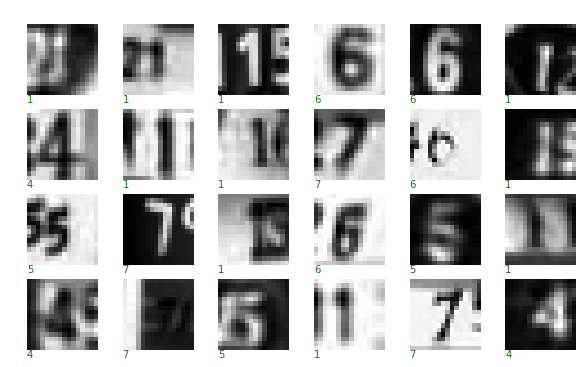

In [6]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [13]:
ex1_model = Sequential([
    Dense(5, input_shape=(256,), activation='softmax'),
])

ex1_model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
ex1_history = ex1_model.fit(x_train, y_train, epochs=300, validation_data=(x_test,y_test), batch_size=128, verbose=1)

Train on 39523 samples, validate on 14002 samples
Epoch 1/300
39523/39523 [==============================] - 1s 14us/step - loss: 1.5712 - acc: 0.3322 - val_loss: 1.5571 - val_acc: 0.3574
Epoch 2/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.5545 - acc: 0.3498 - val_loss: 1.5453 - val_acc: 0.3621
Epoch 3/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.5469 - acc: 0.3510 - val_loss: 1.5392 - val_acc: 0.3641
Epoch 4/300
39523/39523 [==============================] - 1s 19us/step - loss: 1.5417 - acc: 0.3521 - val_loss: 1.5344 - val_acc: 0.3659
Epoch 5/300
39523/39523 [==============================] - 0s 13us/step - loss: 1.5379 - acc: 0.3530 - val_loss: 1.5318 - val_acc: 0.3697
Epoch 6/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.5350 - acc: 0.3537 - val_loss: 1.5287 - val_acc: 0.3690
Epoch 7/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.5326 - acc: 0.3539 - val_loss: 1.5269 - 

39523/39523 [==============================] - 0s 11us/step - loss: 1.4982 - acc: 0.3828 - val_loss: 1.5127 - val_acc: 0.4074
Epoch 60/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4980 - acc: 0.3834 - val_loss: 1.5120 - val_acc: 0.4043
Epoch 61/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4978 - acc: 0.3836 - val_loss: 1.5124 - val_acc: 0.4041
Epoch 62/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4975 - acc: 0.3839 - val_loss: 1.5125 - val_acc: 0.4079
Epoch 63/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4973 - acc: 0.3843 - val_loss: 1.5120 - val_acc: 0.4027
Epoch 64/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4971 - acc: 0.3841 - val_loss: 1.5133 - val_acc: 0.4105
Epoch 65/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4968 - acc: 0.3848 - val_loss: 1.5128 - val_acc: 0.4058
Epoch 66/300
39523/39523 [==============

Epoch 118/300
39523/39523 [==============================] - 1s 15us/step - loss: 1.4890 - acc: 0.3951 - val_loss: 1.5153 - val_acc: 0.4102
Epoch 119/300
39523/39523 [==============================] - 1s 14us/step - loss: 1.4890 - acc: 0.3949 - val_loss: 1.5153 - val_acc: 0.4135
Epoch 120/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.4889 - acc: 0.3954 - val_loss: 1.5152 - val_acc: 0.4118
Epoch 121/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.4888 - acc: 0.3955 - val_loss: 1.5157 - val_acc: 0.4137
Epoch 122/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.4886 - acc: 0.3952 - val_loss: 1.5158 - val_acc: 0.4127
Epoch 123/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.4885 - acc: 0.3950 - val_loss: 1.5154 - val_acc: 0.4129
Epoch 124/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.4884 - acc: 0.3961 - val_loss: 1.5164 - val_acc: 0.4154
Epoch 125/300
39523/

39523/39523 [==============================] - 1s 13us/step - loss: 1.4846 - acc: 0.4005 - val_loss: 1.5187 - val_acc: 0.4157
Epoch 177/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.4846 - acc: 0.4004 - val_loss: 1.5183 - val_acc: 0.4144
Epoch 178/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.4845 - acc: 0.4007 - val_loss: 1.5186 - val_acc: 0.4154
Epoch 179/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.4844 - acc: 0.4005 - val_loss: 1.5184 - val_acc: 0.4150
Epoch 180/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.4843 - acc: 0.4001 - val_loss: 1.5185 - val_acc: 0.4159
Epoch 181/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.4843 - acc: 0.4010 - val_loss: 1.5183 - val_acc: 0.4143
Epoch 182/300
39523/39523 [==============================] - 0s 13us/step - loss: 1.4841 - acc: 0.4007 - val_loss: 1.5189 - val_acc: 0.4164
Epoch 183/300
39523/39523 [=======

39523/39523 [==============================] - 0s 12us/step - loss: 1.4817 - acc: 0.4037 - val_loss: 1.5205 - val_acc: 0.4174
Epoch 235/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4817 - acc: 0.4039 - val_loss: 1.5206 - val_acc: 0.4165
Epoch 236/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4816 - acc: 0.4043 - val_loss: 1.5204 - val_acc: 0.4156
Epoch 237/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4816 - acc: 0.4047 - val_loss: 1.5199 - val_acc: 0.4133
Epoch 238/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4816 - acc: 0.4039 - val_loss: 1.5203 - val_acc: 0.4162
Epoch 239/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4814 - acc: 0.4045 - val_loss: 1.5212 - val_acc: 0.4167
Epoch 240/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4815 - acc: 0.4044 - val_loss: 1.5201 - val_acc: 0.4147
Epoch 241/300
39523/39523 [=======

39523/39523 [==============================] - 1s 13us/step - loss: 1.4797 - acc: 0.4059 - val_loss: 1.5217 - val_acc: 0.4156
Epoch 293/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.4796 - acc: 0.4057 - val_loss: 1.5228 - val_acc: 0.4197
Epoch 294/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.4794 - acc: 0.4070 - val_loss: 1.5231 - val_acc: 0.4189
Epoch 295/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.4795 - acc: 0.4060 - val_loss: 1.5217 - val_acc: 0.4159
Epoch 296/300
39523/39523 [==============================] - 1s 14us/step - loss: 1.4795 - acc: 0.4063 - val_loss: 1.5217 - val_acc: 0.4170
Epoch 297/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.4795 - acc: 0.4070 - val_loss: 1.5217 - val_acc: 0.4158
Epoch 298/300
39523/39523 [==============================] - 1s 13us/step - loss: 1.4795 - acc: 0.4068 - val_loss: 1.5224 - val_acc: 0.4187
Epoch 299/300
39523/39523 [=======

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5)                 1285      
Total params: 1,285
Trainable params: 1,285
Non-trainable params: 0
_________________________________________________________________


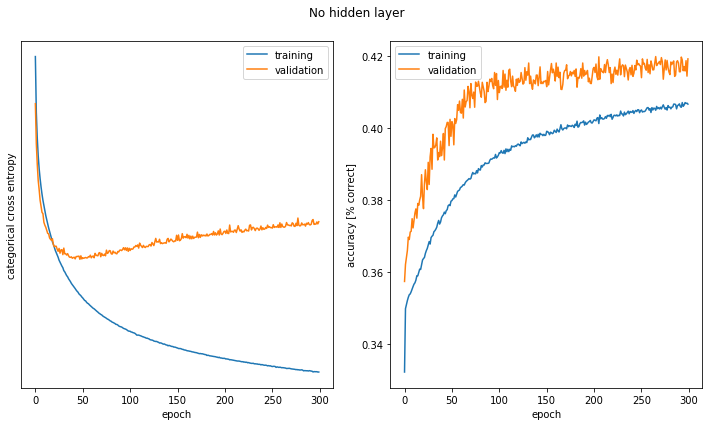

In [14]:
ex1_model.summary()
plot_history(ex1_history, "No hidden layer")
plt.show()

In [15]:
score = ex1_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.52242729181
Test accuracy: 0.419154406514


In [16]:
yhat_test = ex1_model.predict_on_batch(x_test)
error = np.linalg.norm(((yhat_test.round()) - y_test),axis=1)
error_indices = np.nonzero(error)[0]

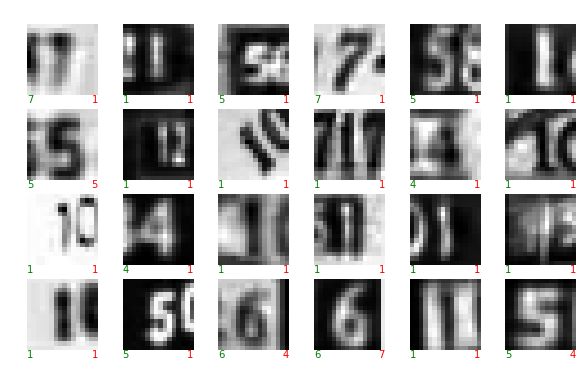

In [17]:
plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)
plt.show()

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [18]:
ex2_model_sgd = Sequential([
    Dense(64, input_shape=(256,), activation='relu'),
    Dense(5, activation='softmax'),
])

ex2_model_sgd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [19]:
lrates = [0.01, 0.05, 0.1, 0.5, 1, 2]
histories = []
for lrate in lrates:
    ex2_model_sgd.compile(optimizer=SGD(lr=lrate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    histories.append(
        ex2_model_sgd.fit(x_train, y_train, epochs=50, validation_data=(x_test,y_test), batch_size=128, verbose=1))

Train on 39523 samples, validate on 14002 samples
Epoch 1/50
39523/39523 [==============================] - 1s 18us/step - loss: 1.5681 - acc: 0.3330 - val_loss: 1.5450 - val_acc: 0.3641
Epoch 2/50
39523/39523 [==============================] - 1s 16us/step - loss: 1.5421 - acc: 0.3506 - val_loss: 1.5317 - val_acc: 0.3643
Epoch 3/50
39523/39523 [==============================] - 1s 16us/step - loss: 1.5316 - acc: 0.3505 - val_loss: 1.5206 - val_acc: 0.3646
Epoch 4/50
39523/39523 [==============================] - 1s 16us/step - loss: 1.5229 - acc: 0.3507 - val_loss: 1.5096 - val_acc: 0.3647
Epoch 5/50
39523/39523 [==============================] - 1s 16us/step - loss: 1.5141 - acc: 0.3513 - val_loss: 1.5001 - val_acc: 0.3684
Epoch 6/50
39523/39523 [==============================] - 1s 16us/step - loss: 1.5045 - acc: 0.3528 - val_loss: 1.4895 - val_acc: 0.3782
Epoch 7/50
39523/39523 [==============================] - 1s 16us/step - loss: 1.4935 - acc: 0.3556 - val_loss: 1.4763 - val_acc

Epoch 10/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.6430 - acc: 0.8041 - val_loss: 0.7107 - val_acc: 0.7810
Epoch 11/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.6322 - acc: 0.8070 - val_loss: 0.7054 - val_acc: 0.7843
Epoch 12/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.6245 - acc: 0.8102 - val_loss: 0.7089 - val_acc: 0.7862
Epoch 13/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.6167 - acc: 0.8124 - val_loss: 0.6942 - val_acc: 0.7879
Epoch 14/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.6094 - acc: 0.8154 - val_loss: 0.6964 - val_acc: 0.7890
Epoch 15/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.6030 - acc: 0.8152 - val_loss: 0.6878 - val_acc: 0.7880
Epoch 16/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.5956 - acc: 0.8193 - val_loss: 0.6764 - val_acc: 0.7947
Epoch 17/50
39523/39523 [=========

39523/39523 [==============================] - 1s 16us/step - loss: 0.4122 - acc: 0.8750 - val_loss: 0.5365 - val_acc: 0.8507
Epoch 20/50
39523/39523 [==============================] - 1s 18us/step - loss: 0.4082 - acc: 0.8772 - val_loss: 0.5258 - val_acc: 0.8570
Epoch 21/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.4023 - acc: 0.8794 - val_loss: 0.6083 - val_acc: 0.8326
Epoch 22/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.4024 - acc: 0.8781 - val_loss: 0.5201 - val_acc: 0.8567
Epoch 23/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.3976 - acc: 0.8798 - val_loss: 0.5246 - val_acc: 0.8587
Epoch 24/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.3955 - acc: 0.8814 - val_loss: 0.5290 - val_acc: 0.8543
Epoch 25/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.3948 - acc: 0.8832 - val_loss: 0.5554 - val_acc: 0.8448
Epoch 26/50
39523/39523 [=====================

39523/39523 [==============================] - 1s 17us/step - loss: 0.3748 - acc: 0.8847 - val_loss: 0.5705 - val_acc: 0.8482
Epoch 29/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.3819 - acc: 0.8809 - val_loss: 0.5331 - val_acc: 0.8603
Epoch 30/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.3759 - acc: 0.8852 - val_loss: 0.5507 - val_acc: 0.8527
Epoch 31/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.3700 - acc: 0.8861 - val_loss: 0.5264 - val_acc: 0.8617
Epoch 32/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.3725 - acc: 0.8857 - val_loss: 0.5501 - val_acc: 0.8542
Epoch 33/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.3649 - acc: 0.8873 - val_loss: 0.6006 - val_acc: 0.8423
Epoch 34/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.3687 - acc: 0.8849 - val_loss: 0.5334 - val_acc: 0.8646
Epoch 35/50
39523/39523 [=====================

39523/39523 [==============================] - 2s 42us/step - loss: 0.3693 - acc: 0.8845 - val_loss: 0.5745 - val_acc: 0.8520
Epoch 38/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.3621 - acc: 0.8874 - val_loss: 0.7351 - val_acc: 0.8082
Epoch 39/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.3669 - acc: 0.8851 - val_loss: 1.5241 - val_acc: 0.7026
Epoch 40/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.3736 - acc: 0.8840 - val_loss: 0.5766 - val_acc: 0.8597
Epoch 41/50
39523/39523 [==============================] - 1s 31us/step - loss: 0.3632 - acc: 0.8864 - val_loss: 0.6155 - val_acc: 0.8524
Epoch 42/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.3608 - acc: 0.8856 - val_loss: 0.5989 - val_acc: 0.8525
Epoch 43/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.3623 - acc: 0.8882 - val_loss: 0.5881 - val_acc: 0.8522
Epoch 44/50
39523/39523 [=====================

39523/39523 [==============================] - 1s 16us/step - loss: 0.4367 - acc: 0.8659 - val_loss: 0.6744 - val_acc: 0.8415
Epoch 47/50
39523/39523 [==============================] - 1s 27us/step - loss: 0.4421 - acc: 0.8649 - val_loss: 0.6539 - val_acc: 0.8440
Epoch 48/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.4352 - acc: 0.8665 - val_loss: 0.8054 - val_acc: 0.8066
Epoch 49/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.4728 - acc: 0.8556 - val_loss: 0.7441 - val_acc: 0.8207
Epoch 50/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.4505 - acc: 0.8609 - val_loss: 0.6901 - val_acc: 0.8312


In [22]:
print("LR loss acc val_loss val_acc")
for lr, h in zip(lrates, histories):
    print(lr, h.history.get('loss')[-1], h.history.get('acc')[-1], 
          h.history.get('val_loss')[-1], h.history.get('val_acc')[-1])

LR loss acc val_loss val_acc
0.01 0.803093716481 0.747539407364 0.84257540744 0.731252678129
0.05 0.462125976798 0.862232117951 0.585931556086 0.830524210801
0.1 0.347011797332 0.895276168251 0.509456901384 0.864376517598
0.5 0.347357477911 0.891455608097 0.576688176644 0.848593058177
1 0.354055599856 0.889279660008 0.586119809401 0.855020711225
2 0.450515052246 0.86094173017 0.690139318888 0.831238394549


**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) If the learning rate is too large, the solucion may oscillate around a value and never achieve a minimum. It may even lead to increasing error during the training period obtening very poor results.

B) If the learning rate is too small, the improvement per epoch may be too small too and so, the number of epochs needed to achieve a reasonable results may be extremly large. 

In [23]:
ex2_model_ada = Sequential([
    Dense(64, input_shape=(256,), activation='relu'),
    Dense(5, activation='softmax'),
])

ex2_model_ada.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [24]:
ex2_model_ada.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

adam_history = ex2_model_ada.fit(
    x_train, y_train, epochs=50, validation_data=(x_test,y_test), batch_size=128, verbose=1)

Train on 39523 samples, validate on 14002 samples
Epoch 1/50
39523/39523 [==============================] - 2s 47us/step - loss: 1.3946 - acc: 0.4203 - val_loss: 1.1420 - val_acc: 0.5832
Epoch 2/50
39523/39523 [==============================] - 1s 18us/step - loss: 1.0023 - acc: 0.6569 - val_loss: 0.9094 - val_acc: 0.6886
Epoch 3/50
39523/39523 [==============================] - 1s 18us/step - loss: 0.8244 - acc: 0.7402 - val_loss: 0.8236 - val_acc: 0.7380
Epoch 4/50
39523/39523 [==============================] - 1s 18us/step - loss: 0.7415 - acc: 0.7699 - val_loss: 0.7730 - val_acc: 0.7627
Epoch 5/50
39523/39523 [==============================] - 1s 18us/step - loss: 0.6901 - acc: 0.7880 - val_loss: 0.7515 - val_acc: 0.7707
Epoch 6/50
39523/39523 [==============================] - 1s 18us/step - loss: 0.6556 - acc: 0.7981 - val_loss: 0.7088 - val_acc: 0.7853
Epoch 7/50
39523/39523 [==============================] - 1s 19us/step - loss: 0.6293 - acc: 0.8078 - val_loss: 0.6915 - val_acc

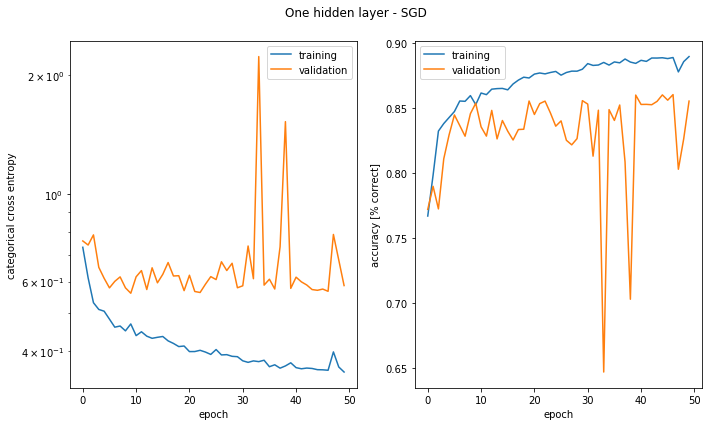

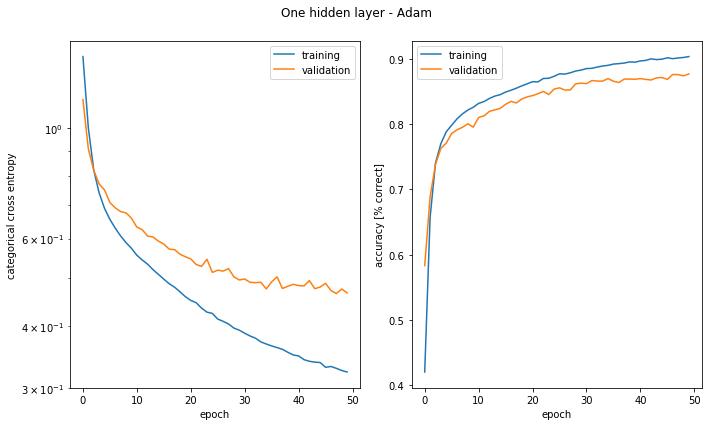

In [26]:
# histories[2] (lr=0.1) gives the best results
plot_history(histories[4], "One hidden layer - SGD")
plot_history(adam_history, "One hidden layer - Adam")
plt.show()

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [31]:
ex3_model = Sequential([
    Dense(64, input_shape=(256,), activation="relu"),
    Dense(5, activation="softmax"),
])

ex3_model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

ex3_history = ex3_model.fit(
    x_train, y_train, epochs=500, validation_data=(x_test,y_test), batch_size=128, verbose=1)

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 1s 25us/step - loss: 1.4178 - acc: 0.4125 - val_loss: 1.2027 - val_acc: 0.5816
Epoch 2/500
39523/39523 [==============================] - 1s 17us/step - loss: 1.0476 - acc: 0.6281 - val_loss: 0.9390 - val_acc: 0.6803
Epoch 3/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.8536 - acc: 0.7251 - val_loss: 0.8609 - val_acc: 0.7178
Epoch 4/500
39523/39523 [==============================] - 1s 30us/step - loss: 0.7649 - acc: 0.7608 - val_loss: 0.7963 - val_acc: 0.7507
Epoch 5/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.7072 - acc: 0.7804 - val_loss: 0.7640 - val_acc: 0.7633
Epoch 6/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.6708 - acc: 0.7924 - val_loss: 0.7211 - val_acc: 0.7781
Epoch 7/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.6349 - acc: 0.8062 - val_loss: 0.7048 - 

39523/39523 [==============================] - 1s 21us/step - loss: 0.3184 - acc: 0.9037 - val_loss: 0.4835 - val_acc: 0.8731
Epoch 60/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3153 - acc: 0.9049 - val_loss: 0.4763 - val_acc: 0.8762
Epoch 61/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.3167 - acc: 0.9040 - val_loss: 0.4841 - val_acc: 0.8712
Epoch 62/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.3116 - acc: 0.9065 - val_loss: 0.4797 - val_acc: 0.8742
Epoch 63/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3120 - acc: 0.9066 - val_loss: 0.4871 - val_acc: 0.8737
Epoch 64/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3083 - acc: 0.9072 - val_loss: 0.4776 - val_acc: 0.8749
Epoch 65/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3085 - acc: 0.9067 - val_loss: 0.5073 - val_acc: 0.8634
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2519 - acc: 0.9229 - val_loss: 0.5002 - val_acc: 0.8761
Epoch 119/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2522 - acc: 0.9221 - val_loss: 0.5032 - val_acc: 0.8792
Epoch 120/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2495 - acc: 0.9246 - val_loss: 0.4967 - val_acc: 0.8811
Epoch 121/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2493 - acc: 0.9246 - val_loss: 0.4922 - val_acc: 0.8794
Epoch 122/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2508 - acc: 0.9238 - val_loss: 0.5007 - val_acc: 0.8790
Epoch 123/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2488 - acc: 0.9241 - val_loss: 0.4875 - val_acc: 0.8824
Epoch 124/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2462 - acc: 0.9251 - val_loss: 0.4992 - val_acc: 0.8819
Epoch 125/500
39523/

39523/39523 [==============================] - 1s 17us/step - loss: 0.2176 - acc: 0.9337 - val_loss: 0.5183 - val_acc: 0.8809
Epoch 177/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.2177 - acc: 0.9330 - val_loss: 0.5135 - val_acc: 0.8838
Epoch 178/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.2138 - acc: 0.9346 - val_loss: 0.5105 - val_acc: 0.8842
Epoch 179/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2134 - acc: 0.9336 - val_loss: 0.5243 - val_acc: 0.8820
Epoch 180/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2176 - acc: 0.9340 - val_loss: 0.5341 - val_acc: 0.8803
Epoch 181/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.2166 - acc: 0.9328 - val_loss: 0.5457 - val_acc: 0.8769
Epoch 182/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.2170 - acc: 0.9323 - val_loss: 0.5255 - val_acc: 0.8797
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 1s 17us/step - loss: 0.1983 - acc: 0.9391 - val_loss: 0.5507 - val_acc: 0.8810
Epoch 235/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.1960 - acc: 0.9399 - val_loss: 0.5351 - val_acc: 0.8842
Epoch 236/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1925 - acc: 0.9399 - val_loss: 0.5406 - val_acc: 0.8862
Epoch 237/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1961 - acc: 0.9388 - val_loss: 0.5468 - val_acc: 0.8822
Epoch 238/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.1973 - acc: 0.9391 - val_loss: 0.5363 - val_acc: 0.8852
Epoch 239/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.1947 - acc: 0.9413 - val_loss: 0.5575 - val_acc: 0.8791
Epoch 240/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1939 - acc: 0.9411 - val_loss: 0.5463 - val_acc: 0.8845
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 1s 17us/step - loss: 0.1790 - acc: 0.9444 - val_loss: 0.5715 - val_acc: 0.8831
Epoch 293/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1763 - acc: 0.9458 - val_loss: 0.5540 - val_acc: 0.8872
Epoch 294/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1824 - acc: 0.9431 - val_loss: 0.5594 - val_acc: 0.8862
Epoch 295/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1839 - acc: 0.9435 - val_loss: 0.5568 - val_acc: 0.8861
Epoch 296/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1787 - acc: 0.9456 - val_loss: 0.5718 - val_acc: 0.8817
Epoch 297/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1805 - acc: 0.9442 - val_loss: 0.5577 - val_acc: 0.8877
Epoch 298/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1848 - acc: 0.9420 - val_loss: 0.5608 - val_acc: 0.8853
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 1s 17us/step - loss: 0.1693 - acc: 0.9474 - val_loss: 0.6078 - val_acc: 0.8761
Epoch 351/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1678 - acc: 0.9488 - val_loss: 0.5947 - val_acc: 0.8810
Epoch 352/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1685 - acc: 0.9486 - val_loss: 0.5863 - val_acc: 0.8837
Epoch 353/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1686 - acc: 0.9480 - val_loss: 0.5957 - val_acc: 0.8819
Epoch 354/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1690 - acc: 0.9474 - val_loss: 0.6001 - val_acc: 0.8797
Epoch 355/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.1670 - acc: 0.9484 - val_loss: 0.5855 - val_acc: 0.8857
Epoch 356/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1703 - acc: 0.9465 - val_loss: 0.5808 - val_acc: 0.8868
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 1s 18us/step - loss: 0.1628 - acc: 0.9490 - val_loss: 0.6036 - val_acc: 0.8847
Epoch 409/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.1608 - acc: 0.9506 - val_loss: 0.6058 - val_acc: 0.8837
Epoch 410/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1662 - acc: 0.9492 - val_loss: 0.6679 - val_acc: 0.8664
Epoch 411/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.1661 - acc: 0.9480 - val_loss: 0.5984 - val_acc: 0.8872
Epoch 412/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1600 - acc: 0.9506 - val_loss: 0.6142 - val_acc: 0.8839
Epoch 413/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1573 - acc: 0.9502 - val_loss: 0.6063 - val_acc: 0.8856
Epoch 414/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1592 - acc: 0.9515 - val_loss: 0.6067 - val_acc: 0.8855
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 1s 17us/step - loss: 0.1518 - acc: 0.9530 - val_loss: 0.6281 - val_acc: 0.8802
Epoch 467/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1496 - acc: 0.9544 - val_loss: 0.6627 - val_acc: 0.8773
Epoch 468/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1546 - acc: 0.9517 - val_loss: 0.6336 - val_acc: 0.8824
Epoch 469/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1527 - acc: 0.9532 - val_loss: 0.6251 - val_acc: 0.8847
Epoch 470/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1522 - acc: 0.9527 - val_loss: 0.6169 - val_acc: 0.8840
Epoch 471/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.1525 - acc: 0.9524 - val_loss: 0.6167 - val_acc: 0.8884
Epoch 472/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.1537 - acc: 0.9510 - val_loss: 0.6172 - val_acc: 0.8860
Epoch 473/500
39523/39523 [=======

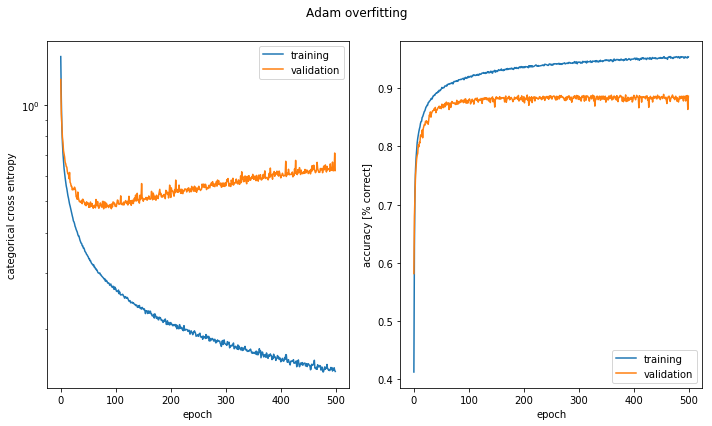

In [32]:
plot_history(ex3_history, "Adam overfitting")
plt.show()

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: 

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

In [ ]:
hidden_n = [10, 50, 100, 200, 300, 400, 500, 1000]

accuracy = {}
losses = {}

for n in hidden_n:
    print("Number of hidden units:", params)
    accuracy[params] = []
    losses[params] = []
    for n in range(5):
        print("Iteration number", n)
        model = Sequential([
            Dense(params, input_shape=(256,), activation='relu'),
            Dense(5, activation='softmax'),
        ])

        model.compile(optimizer=SGD(lr=0.1),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
        h = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=200,  batch_size=128, verbose=0)
        accuracy[params].append(h.history.get('val_acc')[-1]) 
        losses[params].append(h.history.get('val_loss')[-1])

In [ ]:
fig1, axes1 = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharey=False)
fig2, axes2 = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharey=True)
fs = 12
for n in range(len(hidden_n)):
    row = int(n/4)
    col = n%4
    data_loss = losses[hidden_n[n]]
    data_acc = accuracy[hidden_n[n]]
    
    axes1[row, col].boxplot(data_loss, manage_xticks=True)
    axes1[row, col].set_title('LOSS -- Number of hidden units:{}'.format(hidden_n[n]), fontsize=fs)
    
    axes2[row, col].boxplot(data_acc, manage_xticks=True)
    axes2[row, col].set_title('ACCURACY -- Number of hidden units:{}'.format(hidden_n[n]), fontsize=fs)
    
plt.show()

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

In [35]:
models = []
nh_2 = 77
nh_3 = 66
nh_4 = 59

models.append(Sequential([
    Dense(100, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(5, activation='softmax')
]))

models.append(Sequential([
    Dense(nh_2, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(nh_2, activation='relu'),
    Dense(5, activation='softmax')
]))

models.append(Sequential([
    Dense(nh_3, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(nh_3, activation='relu'),
    Dense(nh_3, activation='relu'),
    Dense(5, activation='softmax')
]))

models.append(Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(nh_4, activation='relu'),
    Dense(nh_4, activation='relu'),
    Dense(nh_4, activation='relu'),
    Dense(5, activation='softmax')
]))

for model in models:
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 100)               25700     
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 77)                19789     
_________________________________________________________________
dense_30 (Dense)             (None, 77)                6006      
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
__

In [40]:
accuracy = {}
losses = {}
histories = {}

for i, model in enumerate(models):
    print("Model", i)
    accuracy[model] = []
    losses[model] = []
    histories[model] = []
    for n in range(5):
        print("Iteration number {}".format(n))
        model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
        
        h = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=300,  batch_size=128, verbose=0)
        print('Test accuracy: {}'.format(h.history.get('val_acc')[-1]))
        accuracy[model].append(h.history.get('val_acc')[-1]) 
        print('Test loss: {}'.format(h.history.get('val_loss')[-1]))
        losses[model].append(h.history.get('val_loss')[-1])
        histories[model].append(h)

Model 0
Iteration number 0
Test accuracy: 0.8940151406005354
Test loss: 0.465068460762322
Iteration number 1
Test accuracy: 0.8940151406005354
Test loss: 0.47497055329113175
Iteration number 2
Test accuracy: 0.894657906064509
Test loss: 0.4875893510166125
Iteration number 3
Test accuracy: 0.8940151406005354
Test loss: 0.49855624898946754
Iteration number 4
Test accuracy: 0.8940151406005354
Test loss: 0.5094365430225595
Model 1
Iteration number 0
Test accuracy: 0.8868018853512853
Test loss: 0.7339277003019508
Iteration number 1
Test accuracy: 0.8808027425164445
Test loss: 0.8227784731544404
Iteration number 2
Test accuracy: 0.8823739466301426
Test loss: 0.8551881896003861
Iteration number 3
Test accuracy: 0.8817311813109024
Test loss: 0.9013541039186381
Iteration number 4
Test accuracy: 0.8803742323036178
Test loss: 0.9533439170052505
Model 2
Iteration number 0
Test accuracy: 0.8669475789598662
Test loss: 1.105789653489699
Iteration number 1
Test accuracy: 0.8725896299591985
Test loss: 

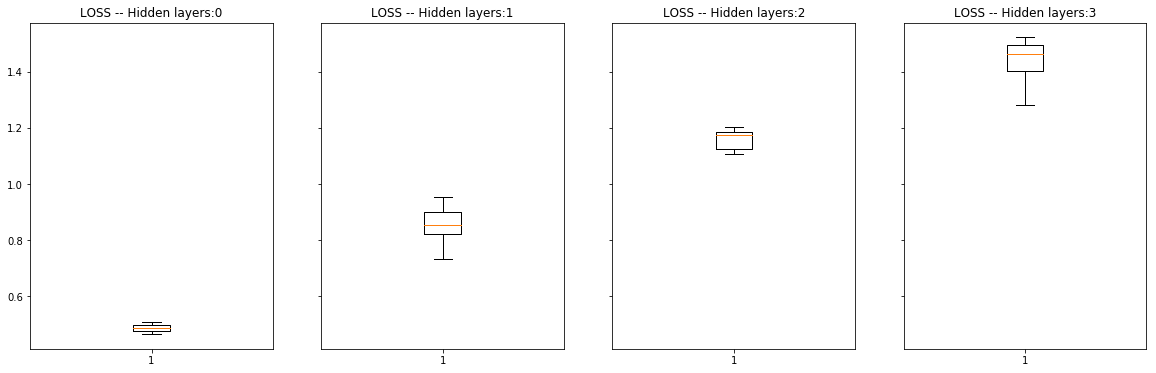

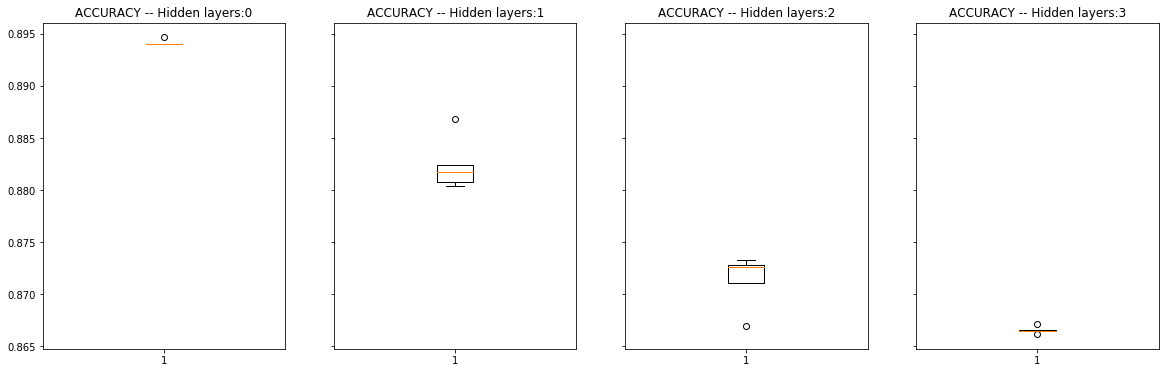

In [41]:
fig1, axes1 = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), sharey=True)
fig2, axes2 = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), sharey=True)
fs = 12

for n in range(len(models)):
    row = 0
    col = n%4

    data_loss = losses[models[n]]
    data_acc = accuracy[models[n]]
    
    axes1[col].boxplot(data_loss, manage_xticks=True)
    axes1[col].set_title('LOSS -- Hidden layers:{}'.format(n), fontsize=fs)
    
    axes2[col].boxplot(data_acc, manage_xticks=True)
    axes2[col].set_title('ACCURACY -- Hidden layers:{}'.format(n), fontsize=fs)
    
plt.show()

In [42]:
plot_history(histories[0][0],'1 layer 100 units')
plot_history(histories[1][0],'2 layers 77 units')
plot_history(histories[2][0],'3 layers 66 units')
plot_history(histories[3][0],'4 layers 59 units')

KeyError: 0

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

In [47]:
model = Sequential([
    Dense(100, 
          input_shape=(256,), 
          activation='relu', 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform',
          kernel_regularizer=regularizers.l2(0.0005),
          bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dense(5, activation='softmax')
])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h1 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h1.history.get('acc')[-1])
print("Val Accuracy", h1.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 3s 77us/step - loss: 1.2939 - acc: 0.5252 - val_loss: 1.0649 - val_acc: 0.5893
Epoch 2/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.9090 - acc: 0.7189 - val_loss: 0.8539 - val_acc: 0.7224
Epoch 3/500
39523/39523 [==============================] - 1s 35us/step - loss: 0.7791 - acc: 0.7634 - val_loss: 0.7904 - val_acc: 0.7478
Epoch 4/500
39523/39523 [==============================] - 1s 29us/step - loss: 0.7114 - acc: 0.7857 - val_loss: 0.7319 - val_acc: 0.7667
Epoch 5/500
39523/39523 [==============================] - 1s 31us/step - loss: 0.6668 - acc: 0.7978 - val_loss: 0.7045 - val_acc: 0.7765
Epoch 6/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.6370 - acc: 0.8098 - val_loss: 0.7276 - val_acc: 0.7666
Epoch 7/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.6094 - acc: 0.8173 - val_loss: 0.6721 - 

39523/39523 [==============================] - 1s 27us/step - loss: 0.3263 - acc: 0.9052 - val_loss: 0.4969 - val_acc: 0.8719
Epoch 60/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.3208 - acc: 0.9056 - val_loss: 0.4822 - val_acc: 0.8769
Epoch 61/500
39523/39523 [==============================] - 2s 57us/step - loss: 0.3222 - acc: 0.9060 - val_loss: 0.4881 - val_acc: 0.8772
Epoch 62/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.3242 - acc: 0.9056 - val_loss: 0.4890 - val_acc: 0.8763
Epoch 63/500
39523/39523 [==============================] - 1s 29us/step - loss: 0.3191 - acc: 0.9076 - val_loss: 0.5105 - val_acc: 0.8660
Epoch 64/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.3222 - acc: 0.9056 - val_loss: 0.4871 - val_acc: 0.8744
Epoch 65/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.3193 - acc: 0.9073 - val_loss: 0.5319 - val_acc: 0.8625
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2731 - acc: 0.9214 - val_loss: 0.5306 - val_acc: 0.8712
Epoch 119/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2761 - acc: 0.9212 - val_loss: 0.5061 - val_acc: 0.8773
Epoch 120/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2806 - acc: 0.9189 - val_loss: 0.6214 - val_acc: 0.8454
Epoch 121/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2759 - acc: 0.9202 - val_loss: 0.5229 - val_acc: 0.8735
Epoch 122/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2747 - acc: 0.9210 - val_loss: 0.5468 - val_acc: 0.8677
Epoch 123/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2742 - acc: 0.9205 - val_loss: 0.5654 - val_acc: 0.8615
Epoch 124/500
39523/39523 [==============================] - 2s 57us/step - loss: 0.2733 - acc: 0.9205 - val_loss: 0.4980 - val_acc: 0.8821
Epoch 125/500
39523/

39523/39523 [==============================] - 1s 28us/step - loss: 0.2569 - acc: 0.9273 - val_loss: 0.5644 - val_acc: 0.8718
Epoch 177/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2547 - acc: 0.9278 - val_loss: 0.5887 - val_acc: 0.8602
Epoch 178/500
39523/39523 [==============================] - 2s 53us/step - loss: 0.2577 - acc: 0.9272 - val_loss: 0.5508 - val_acc: 0.8687
Epoch 179/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.2518 - acc: 0.9287 - val_loss: 0.5662 - val_acc: 0.8697
Epoch 180/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2541 - acc: 0.9282 - val_loss: 0.5749 - val_acc: 0.8649
Epoch 181/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2560 - acc: 0.9276 - val_loss: 0.7062 - val_acc: 0.8358
Epoch 182/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2508 - acc: 0.9290 - val_loss: 0.5794 - val_acc: 0.8711
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 1s 28us/step - loss: 0.2432 - acc: 0.9319 - val_loss: 0.5659 - val_acc: 0.8754
Epoch 235/500
39523/39523 [==============================] - 1s 30us/step - loss: 0.2383 - acc: 0.9335 - val_loss: 0.5790 - val_acc: 0.8762
Epoch 236/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2436 - acc: 0.9317 - val_loss: 0.5685 - val_acc: 0.8765
Epoch 237/500
39523/39523 [==============================] - 1s 31us/step - loss: 0.2453 - acc: 0.9316 - val_loss: 0.6075 - val_acc: 0.8682
Epoch 238/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2433 - acc: 0.9319 - val_loss: 0.5688 - val_acc: 0.8752
Epoch 239/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2393 - acc: 0.9328 - val_loss: 0.6426 - val_acc: 0.8599
Epoch 240/500
39523/39523 [==============================] - 1s 37us/step - loss: 0.2438 - acc: 0.9314 - val_loss: 0.5495 - val_acc: 0.8773
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 1s 28us/step - loss: 0.2311 - acc: 0.9369 - val_loss: 1.2458 - val_acc: 0.7356
Epoch 293/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2298 - acc: 0.9359 - val_loss: 0.6232 - val_acc: 0.8700
Epoch 294/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2330 - acc: 0.9360 - val_loss: 0.5599 - val_acc: 0.8804
Epoch 295/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2324 - acc: 0.9363 - val_loss: 0.6015 - val_acc: 0.8698
Epoch 296/500
39523/39523 [==============================] - 1s 33us/step - loss: 0.2325 - acc: 0.9353 - val_loss: 0.5857 - val_acc: 0.8760
Epoch 297/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2314 - acc: 0.9365 - val_loss: 0.7520 - val_acc: 0.8475
Epoch 298/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.2287 - acc: 0.9380 - val_loss: 0.7180 - val_acc: 0.8415
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 1s 25us/step - loss: 0.2333 - acc: 0.9372 - val_loss: 0.6284 - val_acc: 0.8702
Epoch 351/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2241 - acc: 0.9398 - val_loss: 0.6521 - val_acc: 0.8676
Epoch 352/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2318 - acc: 0.9378 - val_loss: 0.7770 - val_acc: 0.8355
Epoch 353/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2298 - acc: 0.9379 - val_loss: 0.7666 - val_acc: 0.8481
Epoch 354/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2273 - acc: 0.9382 - val_loss: 0.6558 - val_acc: 0.8639
Epoch 355/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2261 - acc: 0.9400 - val_loss: 0.6011 - val_acc: 0.8772
Epoch 356/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2286 - acc: 0.9386 - val_loss: 0.6574 - val_acc: 0.8601
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 1s 29us/step - loss: 0.2275 - acc: 0.9392 - val_loss: 0.6909 - val_acc: 0.8597
Epoch 409/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2247 - acc: 0.9404 - val_loss: 0.6753 - val_acc: 0.8644
Epoch 410/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2187 - acc: 0.9421 - val_loss: 0.8293 - val_acc: 0.8385
Epoch 411/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2235 - acc: 0.9408 - val_loss: 0.6540 - val_acc: 0.8674
Epoch 412/500
39523/39523 [==============================] - 1s 29us/step - loss: 0.2250 - acc: 0.9413 - val_loss: 0.7910 - val_acc: 0.8280
Epoch 413/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2334 - acc: 0.9363 - val_loss: 0.6494 - val_acc: 0.8644
Epoch 414/500
39523/39523 [==============================] - 1s 29us/step - loss: 0.2157 - acc: 0.9445 - val_loss: 0.6193 - val_acc: 0.8748
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 1s 28us/step - loss: 0.2203 - acc: 0.9408 - val_loss: 0.6564 - val_acc: 0.8666
Epoch 467/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2226 - acc: 0.9418 - val_loss: 0.6175 - val_acc: 0.8785
Epoch 468/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2207 - acc: 0.9430 - val_loss: 0.6986 - val_acc: 0.8581
Epoch 469/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.2199 - acc: 0.9433 - val_loss: 0.6492 - val_acc: 0.8732
Epoch 470/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2202 - acc: 0.9414 - val_loss: 0.7019 - val_acc: 0.8600
Epoch 471/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2270 - acc: 0.9402 - val_loss: 0.6695 - val_acc: 0.8662
Epoch 472/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.2142 - acc: 0.9433 - val_loss: 0.6285 - val_acc: 0.8767
Epoch 473/500
39523/39523 [=======

In [48]:
model = Sequential([
    Dense(100, 
          input_shape=(256,), 
          activation='relu', 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'),
    Dense(5, activation='softmax')
])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h2 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h2.history.get('acc')[-1])
print("Val Accuracy", h2.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 2s 49us/step - loss: 1.5538 - acc: 0.3507 - val_loss: 1.5353 - val_acc: 0.3642
Epoch 2/500
39523/39523 [==============================] - 1s 23us/step - loss: 1.5369 - acc: 0.3507 - val_loss: 1.5204 - val_acc: 0.3642
Epoch 3/500
39523/39523 [==============================] - 1s 20us/step - loss: 1.5258 - acc: 0.3507 - val_loss: 1.5079 - val_acc: 0.3642
Epoch 4/500
39523/39523 [==============================] - 1s 20us/step - loss: 1.5150 - acc: 0.3510 - val_loss: 1.4962 - val_acc: 0.3657
Epoch 5/500
39523/39523 [==============================] - 1s 20us/step - loss: 1.5032 - acc: 0.3519 - val_loss: 1.4819 - val_acc: 0.3687
Epoch 6/500
39523/39523 [==============================] - 1s 20us/step - loss: 1.4900 - acc: 0.3536 - val_loss: 1.4682 - val_acc: 0.3805
Epoch 7/500
39523/39523 [==============================] - 1s 20us/step - loss: 1.4752 - acc: 0.3572 - val_loss: 1.4504 - 

39523/39523 [==============================] - 2s 44us/step - loss: 0.7258 - acc: 0.7801 - val_loss: 0.7824 - val_acc: 0.7557
Epoch 60/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.7214 - acc: 0.7814 - val_loss: 0.7787 - val_acc: 0.7580
Epoch 61/500
39523/39523 [==============================] - 1s 32us/step - loss: 0.7168 - acc: 0.7831 - val_loss: 0.7747 - val_acc: 0.7585
Epoch 62/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.7125 - acc: 0.7840 - val_loss: 0.7733 - val_acc: 0.7595
Epoch 63/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.7085 - acc: 0.7858 - val_loss: 0.7678 - val_acc: 0.7612
Epoch 64/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.7047 - acc: 0.7871 - val_loss: 0.7653 - val_acc: 0.7634
Epoch 65/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.7007 - acc: 0.7883 - val_loss: 0.7634 - val_acc: 0.7620
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.5780 - acc: 0.8263 - val_loss: 0.6627 - val_acc: 0.7981
Epoch 119/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.5763 - acc: 0.8275 - val_loss: 0.6616 - val_acc: 0.7980
Epoch 120/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.5749 - acc: 0.8280 - val_loss: 0.6602 - val_acc: 0.7980
Epoch 121/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5735 - acc: 0.8275 - val_loss: 0.6607 - val_acc: 0.7990
Epoch 122/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5719 - acc: 0.8283 - val_loss: 0.6628 - val_acc: 0.7956
Epoch 123/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5707 - acc: 0.8291 - val_loss: 0.6581 - val_acc: 0.7979
Epoch 124/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.5694 - acc: 0.8287 - val_loss: 0.6572 - val_acc: 0.7988
Epoch 125/500
39523/

39523/39523 [==============================] - 1s 19us/step - loss: 0.5091 - acc: 0.8486 - val_loss: 0.6023 - val_acc: 0.8181
Epoch 177/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5083 - acc: 0.8479 - val_loss: 0.6017 - val_acc: 0.8206
Epoch 178/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.5070 - acc: 0.8488 - val_loss: 0.6031 - val_acc: 0.8192
Epoch 179/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.5062 - acc: 0.8487 - val_loss: 0.6018 - val_acc: 0.8193
Epoch 180/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5052 - acc: 0.8496 - val_loss: 0.5986 - val_acc: 0.8207
Epoch 181/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.5040 - acc: 0.8495 - val_loss: 0.5994 - val_acc: 0.8201
Epoch 182/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.5034 - acc: 0.8498 - val_loss: 0.5971 - val_acc: 0.8214
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 1s 19us/step - loss: 0.4579 - acc: 0.8651 - val_loss: 0.5569 - val_acc: 0.8372
Epoch 235/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.4574 - acc: 0.8645 - val_loss: 0.5550 - val_acc: 0.8385
Epoch 236/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4563 - acc: 0.8651 - val_loss: 0.5562 - val_acc: 0.8386
Epoch 237/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4559 - acc: 0.8653 - val_loss: 0.5548 - val_acc: 0.8387
Epoch 238/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.4549 - acc: 0.8651 - val_loss: 0.5556 - val_acc: 0.8380
Epoch 239/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4542 - acc: 0.8661 - val_loss: 0.5528 - val_acc: 0.8412
Epoch 240/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4534 - acc: 0.8663 - val_loss: 0.5535 - val_acc: 0.8388
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 1s 18us/step - loss: 0.4185 - acc: 0.8773 - val_loss: 0.5224 - val_acc: 0.8519
Epoch 293/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4175 - acc: 0.8780 - val_loss: 0.5247 - val_acc: 0.8510
Epoch 294/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.4168 - acc: 0.8780 - val_loss: 0.5214 - val_acc: 0.8506
Epoch 295/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4164 - acc: 0.8782 - val_loss: 0.5229 - val_acc: 0.8507
Epoch 296/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4161 - acc: 0.8781 - val_loss: 0.5221 - val_acc: 0.8513
Epoch 297/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4156 - acc: 0.8782 - val_loss: 0.5217 - val_acc: 0.8530
Epoch 298/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.4148 - acc: 0.8782 - val_loss: 0.5204 - val_acc: 0.8527
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 1s 35us/step - loss: 0.3860 - acc: 0.8881 - val_loss: 0.4999 - val_acc: 0.8600
Epoch 351/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.3855 - acc: 0.8884 - val_loss: 0.4998 - val_acc: 0.8601
Epoch 352/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.3851 - acc: 0.8885 - val_loss: 0.4976 - val_acc: 0.8614
Epoch 353/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3845 - acc: 0.8887 - val_loss: 0.4988 - val_acc: 0.8621
Epoch 354/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.3842 - acc: 0.8883 - val_loss: 0.4975 - val_acc: 0.8627
Epoch 355/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3835 - acc: 0.8890 - val_loss: 0.4988 - val_acc: 0.8625
Epoch 356/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.3831 - acc: 0.8891 - val_loss: 0.4980 - val_acc: 0.8612
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 1s 19us/step - loss: 0.3593 - acc: 0.8958 - val_loss: 0.4837 - val_acc: 0.8693
Epoch 409/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3590 - acc: 0.8963 - val_loss: 0.4815 - val_acc: 0.8695
Epoch 410/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3587 - acc: 0.8964 - val_loss: 0.4831 - val_acc: 0.8686
Epoch 411/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3582 - acc: 0.8966 - val_loss: 0.4823 - val_acc: 0.8687
Epoch 412/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3579 - acc: 0.8962 - val_loss: 0.4813 - val_acc: 0.8692
Epoch 413/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3571 - acc: 0.8965 - val_loss: 0.4812 - val_acc: 0.8698
Epoch 414/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.3570 - acc: 0.8970 - val_loss: 0.4822 - val_acc: 0.8680
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 1s 18us/step - loss: 0.3380 - acc: 0.9024 - val_loss: 0.4694 - val_acc: 0.8732
Epoch 467/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3373 - acc: 0.9028 - val_loss: 0.4679 - val_acc: 0.8726
Epoch 468/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.3372 - acc: 0.9023 - val_loss: 0.4705 - val_acc: 0.8727
Epoch 469/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.3365 - acc: 0.9020 - val_loss: 0.4702 - val_acc: 0.8744
Epoch 470/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.3364 - acc: 0.9037 - val_loss: 0.4701 - val_acc: 0.8739
Epoch 471/500
39523/39523 [==============================] - 1s 22us/step - loss: 0.3361 - acc: 0.9029 - val_loss: 0.4679 - val_acc: 0.8732
Epoch 472/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.3358 - acc: 0.9037 - val_loss: 0.4697 - val_acc: 0.8725
Epoch 473/500
39523/39523 [=======

In [49]:
model = Sequential([
    Dense(100, 
          input_shape=(256,), 
          activation='relu', 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'),
    BatchNormalization(momentum=0.999),
    Dense(5, activation='softmax')
])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h3 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h3.history.get('acc')[-1])
print("Val Accuracy", h3.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 2s 56us/step - loss: 1.2122 - acc: 0.5632 - val_loss: 0.9602 - val_acc: 0.6838
Epoch 2/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.8671 - acc: 0.7225 - val_loss: 0.8330 - val_acc: 0.7355
Epoch 3/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.7540 - acc: 0.7649 - val_loss: 0.8042 - val_acc: 0.7459
Epoch 4/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.6951 - acc: 0.7853 - val_loss: 0.7328 - val_acc: 0.7763
Epoch 5/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.6528 - acc: 0.7988 - val_loss: 0.6954 - val_acc: 0.7877
Epoch 6/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.6232 - acc: 0.8085 - val_loss: 0.6917 - val_acc: 0.7892
Epoch 7/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.5967 - acc: 0.8163 - val_loss: 0.6746 - 

39523/39523 [==============================] - 1s 26us/step - loss: 0.2936 - acc: 0.9085 - val_loss: 0.4670 - val_acc: 0.8754
Epoch 60/500
39523/39523 [==============================] - 1s 31us/step - loss: 0.2919 - acc: 0.9097 - val_loss: 0.4826 - val_acc: 0.8695
Epoch 61/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2924 - acc: 0.9090 - val_loss: 0.4861 - val_acc: 0.8683
Epoch 62/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2899 - acc: 0.9099 - val_loss: 0.5073 - val_acc: 0.8621
Epoch 63/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2885 - acc: 0.9120 - val_loss: 0.4814 - val_acc: 0.8700
Epoch 64/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2852 - acc: 0.9107 - val_loss: 0.4790 - val_acc: 0.8727
Epoch 65/500
39523/39523 [==============================] - 1s 31us/step - loss: 0.2847 - acc: 0.9094 - val_loss: 0.5616 - val_acc: 0.8505
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2366 - acc: 0.9253 - val_loss: 0.4822 - val_acc: 0.8789
Epoch 119/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2339 - acc: 0.9257 - val_loss: 0.4689 - val_acc: 0.8802
Epoch 120/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2326 - acc: 0.9265 - val_loss: 0.4833 - val_acc: 0.8829
Epoch 121/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2344 - acc: 0.9253 - val_loss: 0.4906 - val_acc: 0.8789
Epoch 122/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2371 - acc: 0.9243 - val_loss: 0.4978 - val_acc: 0.8762
Epoch 123/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2311 - acc: 0.9264 - val_loss: 0.5184 - val_acc: 0.8697
Epoch 124/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2312 - acc: 0.9262 - val_loss: 0.4850 - val_acc: 0.8768
Epoch 125/500
39523/

39523/39523 [==============================] - 1s 26us/step - loss: 0.2036 - acc: 0.9352 - val_loss: 0.4811 - val_acc: 0.8864
Epoch 177/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2071 - acc: 0.9328 - val_loss: 0.4948 - val_acc: 0.8806
Epoch 178/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2035 - acc: 0.9337 - val_loss: 0.5133 - val_acc: 0.8734
Epoch 179/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2009 - acc: 0.9355 - val_loss: 0.5027 - val_acc: 0.8790
Epoch 180/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2054 - acc: 0.9334 - val_loss: 0.5039 - val_acc: 0.8793
Epoch 181/500
39523/39523 [==============================] - 1s 31us/step - loss: 0.2073 - acc: 0.9334 - val_loss: 0.5226 - val_acc: 0.8684
Epoch 182/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2009 - acc: 0.9349 - val_loss: 0.5108 - val_acc: 0.8752
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 1s 29us/step - loss: 0.1865 - acc: 0.9381 - val_loss: 0.5101 - val_acc: 0.8847
Epoch 235/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1845 - acc: 0.9407 - val_loss: 0.5391 - val_acc: 0.8795
Epoch 236/500
39523/39523 [==============================] - 1s 33us/step - loss: 0.1828 - acc: 0.9396 - val_loss: 0.5227 - val_acc: 0.8806
Epoch 237/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1871 - acc: 0.9383 - val_loss: 0.5213 - val_acc: 0.8825
Epoch 238/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1852 - acc: 0.9395 - val_loss: 0.5233 - val_acc: 0.8827
Epoch 239/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1801 - acc: 0.9420 - val_loss: 0.5222 - val_acc: 0.8799
Epoch 240/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1829 - acc: 0.9401 - val_loss: 0.5958 - val_acc: 0.8606
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 1s 35us/step - loss: 0.1721 - acc: 0.9427 - val_loss: 0.5404 - val_acc: 0.8797
Epoch 293/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1709 - acc: 0.9440 - val_loss: 0.5618 - val_acc: 0.8790
Epoch 294/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1717 - acc: 0.9444 - val_loss: 0.5399 - val_acc: 0.8790
Epoch 295/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1658 - acc: 0.9451 - val_loss: 0.5760 - val_acc: 0.8727
Epoch 296/500
39523/39523 [==============================] - 1s 30us/step - loss: 0.1748 - acc: 0.9436 - val_loss: 0.5358 - val_acc: 0.8826
Epoch 297/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1684 - acc: 0.9443 - val_loss: 0.5472 - val_acc: 0.8769
Epoch 298/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1707 - acc: 0.9437 - val_loss: 0.5659 - val_acc: 0.8784
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 1s 26us/step - loss: 0.1594 - acc: 0.9482 - val_loss: 0.5567 - val_acc: 0.8802
Epoch 351/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1603 - acc: 0.9469 - val_loss: 0.5434 - val_acc: 0.8840
Epoch 352/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.1581 - acc: 0.9477 - val_loss: 0.5437 - val_acc: 0.8852
Epoch 353/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1602 - acc: 0.9471 - val_loss: 0.5466 - val_acc: 0.8851
Epoch 354/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1605 - acc: 0.9462 - val_loss: 0.5575 - val_acc: 0.8797
Epoch 355/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1612 - acc: 0.9454 - val_loss: 0.5671 - val_acc: 0.8760
Epoch 356/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.1611 - acc: 0.9462 - val_loss: 0.5483 - val_acc: 0.8837
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 1s 26us/step - loss: 0.1522 - acc: 0.9500 - val_loss: 0.5888 - val_acc: 0.8724
Epoch 409/500
39523/39523 [==============================] - 2s 52us/step - loss: 0.1552 - acc: 0.9485 - val_loss: 0.5634 - val_acc: 0.8837
Epoch 410/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1509 - acc: 0.9502 - val_loss: 0.6569 - val_acc: 0.8563
Epoch 411/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1466 - acc: 0.9513 - val_loss: 0.6250 - val_acc: 0.8700
Epoch 412/500
39523/39523 [==============================] - 2s 51us/step - loss: 0.1556 - acc: 0.9484 - val_loss: 0.6064 - val_acc: 0.8769
Epoch 413/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1480 - acc: 0.9505 - val_loss: 0.5740 - val_acc: 0.8809
Epoch 414/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1469 - acc: 0.9513 - val_loss: 0.5672 - val_acc: 0.8812
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 1s 26us/step - loss: 0.1443 - acc: 0.9525 - val_loss: 0.5963 - val_acc: 0.8797
Epoch 467/500
39523/39523 [==============================] - 1s 31us/step - loss: 0.1467 - acc: 0.9507 - val_loss: 0.6169 - val_acc: 0.8732
Epoch 468/500
39523/39523 [==============================] - 1s 36us/step - loss: 0.1439 - acc: 0.9509 - val_loss: 0.6275 - val_acc: 0.8796
Epoch 469/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1426 - acc: 0.9531 - val_loss: 0.5887 - val_acc: 0.8785
Epoch 470/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.1439 - acc: 0.9519 - val_loss: 0.5836 - val_acc: 0.8829
Epoch 471/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.1423 - acc: 0.9528 - val_loss: 0.6621 - val_acc: 0.8627
Epoch 472/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1426 - acc: 0.9519 - val_loss: 0.5948 - val_acc: 0.8806
Epoch 473/500
39523/39523 [=======

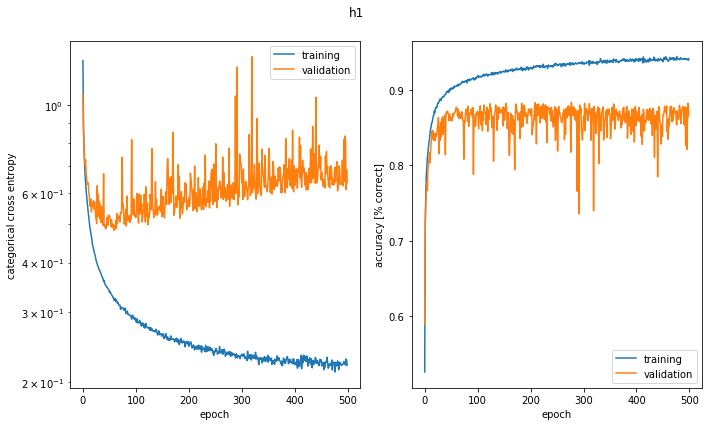

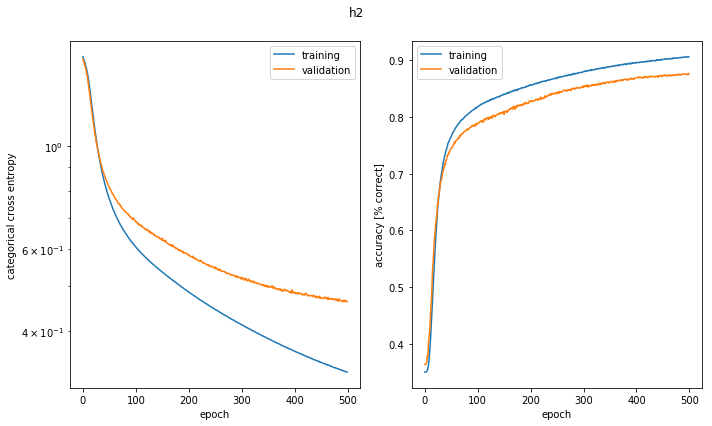

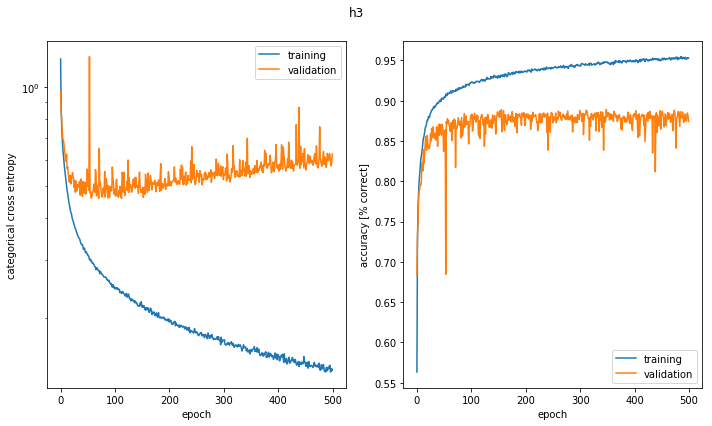

In [52]:
plot_history(h1, "h1")
plt.show()

plot_history(h2, "h2")
plt.show()

plot_history(h3, "h3")
plt.show()

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

In [50]:
x_train_cnn = x_train.reshape(-1,16,16,1)
x_test_cnn = x_test.reshape(-1,16,16,1)

print('x_train shape:', x_train_cnn.shape)
print('x_test shape:', x_test_cnn.shape)
print(x_train_cnn.shape[0], 'train samples')
print(x_test_cnn.shape[0], 'test samples')

input_shape = x_train_cnn.shape
num_classes = 5
batch_size = 128


ex7_model = Sequential()
ex7_model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=(16,16,1)))
ex7_model.add(Conv2D(64, (3, 3), activation='relu'))
ex7_model.add(MaxPooling2D(pool_size=(2, 2)))
ex7_model.add(Conv2D(82, (3, 3), activation='relu'))
ex7_model.add(Dropout(0.5))
ex7_model.add(Flatten())
ex7_model.add(Dense(128, activation='relu'))
ex7_model.add(Dropout(0.5))
ex7_model.add(Dense(num_classes, activation='softmax'))

ex7_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

ex7_model.fit(x_train_cnn, y_train,
          batch_size=128,
          epochs=20,
          verbose=1,
          validation_data=(x_test_cnn, y_test))

score = ex7_model.evaluate(x_test_cnn, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (39523, 16, 16, 1)
x_test shape: (14002, 16, 16, 1)
39523 train samples
14002 test samples
Train on 39523 samples, validate on 14002 samples
Epoch 1/20
39523/39523 [==============================] - 23s 588us/step - loss: 0.9840 - acc: 0.6160 - val_loss: 0.4201 - val_acc: 0.8586
Epoch 2/20
39523/39523 [==============================] - 21s 540us/step - loss: 0.3690 - acc: 0.8793 - val_loss: 0.3055 - val_acc: 0.9025
Epoch 3/20
39523/39523 [==============================] - 22s 545us/step - loss: 0.2911 - acc: 0.9061 - val_loss: 0.2502 - val_acc: 0.9216
Epoch 4/20
39523/39523 [==============================] - 21s 536us/step - loss: 0.2572 - acc: 0.9184 - val_loss: 0.2356 - val_acc: 0.9253
Epoch 5/20
39523/39523 [==============================] - 21s 534us/step - loss: 0.2336 - acc: 0.9249 - val_loss: 0.2114 - val_acc: 0.9343
Epoch 6/20
39523/39523 [==============================] - 22s 558us/step - loss: 0.2187 - acc: 0.9292 - val_loss: 0.2160 - val_acc: 0.9340
Epoch 7/20